In [3]:
import pandas as pd
from matplotlib import pyplot as plt
from random import sample
import numpy as np

In [9]:
df = pd.read_csv("trajectory.csv")
df.columns = ["time", "vehicle_id", "edge", "lane", "x", "y","toremove"]
del df['toremove']
df.head() # df now holds the data

,time,vehicle_id,edge,lane,x,y
0,3,flow_0.0,gneE0,gneE0_1,6.121969,-11.2
1,4,flow_0.0,gneE0,gneE0_1,7.162513,-11.2
2,5,flow_0.0,gneE0,gneE0_1,8.217294,-11.2
3,5,flow_0.1,gneE0,gneE0_3,5.100000,-4.8
4,6,flow_0.0,gneE0,gneE0_1,9.286845,-11.2


In [10]:
# Obtain all the traces of a particular edge, here gneE0 is chosen
# df_edge = df[(df['vehicle_id'].isin(selected_vehicle_ids)) & (df['edge'] == 'gneE0')]
df_edge = df[df['edge'] == 'gneE0']
vehicle_ids_on_edge = df_edge['vehicle_id'].unique().tolist()
selected_vehicle_ids = sample(vehicle_ids_on_edge, 150) # get 100 vehicle traces
df_mini = df[df['vehicle_id'].isin(selected_vehicle_ids)] # get entire vehicle trajectory, not limited to the edge
# df_mini = df_edge[df_edge['vehicle_id'].isin(selected_vehicle_ids)] # get only part of the vehicle trajectory limited to the edge
df_mini.head()

,time,vehicle_id,edge,lane,x,y
0,3,flow_0.0,gneE0,gneE0_1,6.121969,-11.2
1,4,flow_0.0,gneE0,gneE0_1,7.162513,-11.2
2,5,flow_0.0,gneE0,gneE0_1,8.217294,-11.2
4,6,flow_0.0,gneE0,gneE0_1,9.286845,-11.2
6,7,flow_0.0,gneE0,gneE0_1,10.370885,-11.2


Max length of trajectory x: 476
Max length of trajectory y: 476


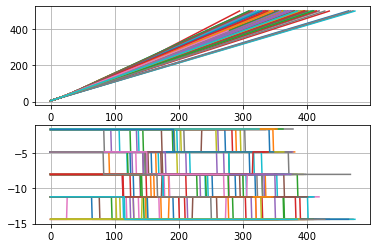

In [11]:
fig = plt.figure()
plt_x = fig.add_subplot(2,1,1)
plt_x.grid(True)
plt_y = fig.add_subplot(2,1,2)
plt_y.grid(True)
max_length_y = 0
max_length_x = 0

for veh_id in selected_vehicle_ids:
    df_of_veh = df_mini[df_mini['vehicle_id'] == veh_id]
    t_vec = df_of_veh['time'].to_numpy()
    t_vec = t_vec - t_vec[0]
    x_vec = df_of_veh['x'].to_numpy()
    y_vec = df_of_veh['y'].to_numpy()
    if x_vec.shape[0] > max_length_x:
        max_length_x = x_vec.shape[0]
    if y_vec.shape[0] > max_length_y:
        max_length_y = y_vec.shape[0]
    plt_x.plot(t_vec, x_vec)
    plt_y.plot(t_vec, y_vec)

print('Max length of trajectory x: {:d}'.format(max_length_x))
print('Max length of trajectory y: {:d}'.format(max_length_y))

Let's add x and y components together!

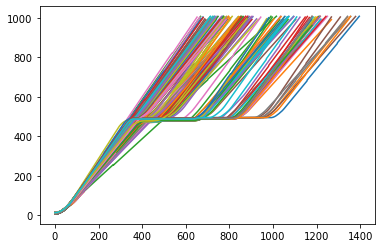

In [ ]:
for veh_id in selected_vehicle_ids:
    df_of_veh = df_mini[df_mini['vehicle_id'] == veh_id]
    t_vec = df_of_veh['time'].to_numpy()
    t_vec = t_vec - t_vec[0]
    x_vec = df_of_veh['x'].to_numpy()
    y_vec = df_of_veh['y'].to_numpy()
    z_vec = x_vec + np.abs(y_vec)
    plt.plot(t_vec, z_vec)

In [ ]:
# Export the data to CSV to be processed with unsupervised segmentation in R
df_mini[['vehicle_id','time','x','y']].to_csv('edge_trajectories.csv')

Linearly extrapolating the trajectories, to capture the effect of the stopping time being a random variable. 

Of course this is not entirely correct, but should be sufficient to illustrate the point about the stopping time.

In [ ]:
z_mat = np.zeros((len(selected_vehicle_ids), max_length_x))
t_mat = None
z_last = np.zeros((len(selected_vehicle_ids,))) # last value of z_vector for each vehicle, for extrapolation!
z_rate = np.zeros((len(selected_vehicle_ids,))) # the speed to linearly extrapolate
z_len = np.zeros((len(selected_vehicle_ids,))) # the speed to linearly extrapolate

for i, veh_id in enumerate(selected_vehicle_ids):
    df_of_veh = df_mini[df_mini['vehicle_id'] == veh_id]
    if t_mat is None:
        t_mat = df_of_veh['time'].to_numpy()
    # t_vec = t_vec - t_vec[0]
    x_vec = df_of_veh['x'].to_numpy()
    y_vec = df_of_veh['y'].to_numpy()
    z_vec = x_vec + np.abs(y_vec)
    z_len[i] = z_vec.shape[0]
    z_mat[i,:z_vec.shape[0]] = z_vec  
    z_last[i] = z_vec[-1]
    z_rate[i] = (z_vec[-1] - z_vec[-4])/3.

In [ ]:
length_desired = 1200
z_cutoff = 600 
z_mat_good = np.zeros((z_mat.shape[0], length_desired))
j=0
for i in range(z_mat.shape[0]):
    if z_len[i] < z_cutoff:
        print('Skipping trajectory {} due to being too short!'.format(i))
        continue
    if z_len[i] > length_desired:
        # just trim this trajectory to length desired
        z_mat_good[j,:] = z_mat[i,:length_desired]
        j+=1
        continue 
    if z_len[i] < length_desired:
        # short (but still good enough to be linearly extrapolated)
        zv = z_mat[i,:int(z_len[i])]
        z_mat_good[j,:zv.shape[0]] = zv
        z_mat_good[j, zv.shape[0]:] = z_last[i] + z_rate[i] * np.arange(1, length_desired - zv.shape[0] + 1)
        j+=1

Skipping trajectory 4 due to being too short!
Skipping trajectory 6 due to being too short!
Skipping trajectory 9 due to being too short!
Skipping trajectory 22 due to being too short!
Skipping trajectory 29 due to being too short!
Skipping trajectory 31 due to being too short!
Skipping trajectory 75 due to being too short!
Skipping trajectory 106 due to being too short!
Skipping trajectory 115 due to being too short!


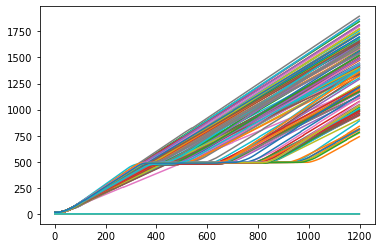

In [ ]:
for i in range(z_mat_good.shape[0]):
    plt.plot(z_mat_good[i,:])

In [ ]:
import pickle 

with open('traj_cont_intersex.pkl', 'wb') as f: 
    pickle.dump(z_mat_good, f)

print('Pickle file written successfully to traj_cont_intersex.pkl')

Pickle file written successfully to traj_cont_intersex.pkl
